# MNIST

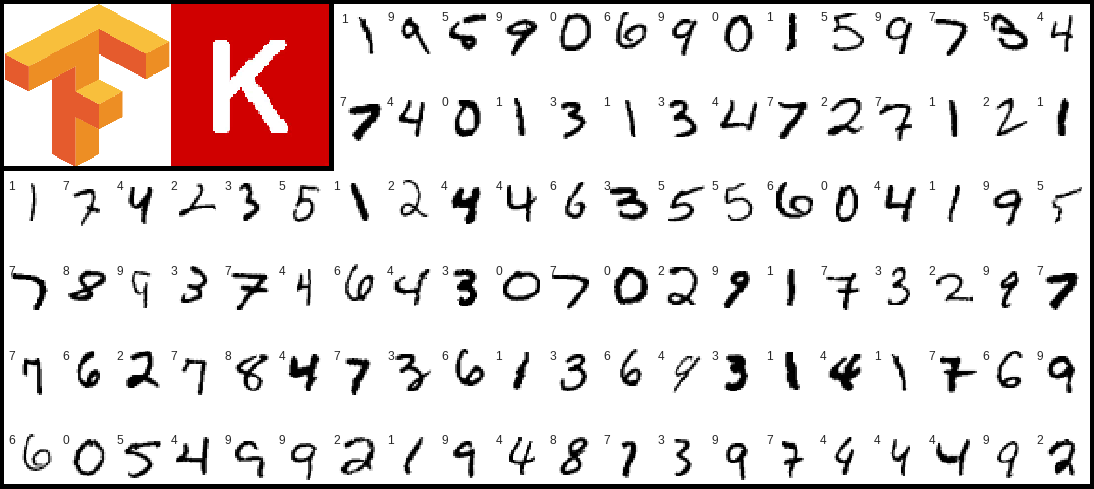

In [1]:
from IPython.display import Image
Image('https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/intro_mnist.png')

In [1]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/fav/train.csv

--2024-01-29 19:16:27--  https://frenzy86.s3.eu-west-2.amazonaws.com/fav/train.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.154, 52.95.149.118, 52.95.191.10, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76775041 (73M) [application/vnd.ms-excel]
Saving to: ‘train.csv’

train.csv           100%[===================>]  73.22M  18.4MB/s    in 4.5s    

2024-01-29 19:16:32 (16.3 MB/s) - ‘train.csv’ saved [76775041/76775041]



In [2]:
import numpy as np
import pandas as pd
import os
#import random as rn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf

In [3]:
img_rows, img_cols = 28, 28
np.random.seed(667)
nr_samples = 30000
#rn.seed(667)
#tf.set_random_seed(667)

In [4]:
#get_best_score for GridSearchCV¶
def get_best_score(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    return model.best_score

In [5]:
# print Classification Report and Accuracy
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))

    return acc_sc

In [6]:
# plot_confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=False, cmap="Blues",ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [7]:
# plot_history_loss_and_acc
def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_keras_nn.history['accuracy'])
    axs[1].plot(history_keras_nn.history['val_accuracy'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

## Loading Data

In [8]:
train = pd.read_csv("train.csv")

In [9]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [11]:
# Features and target
X = train.drop(["label"],axis = 1)
y = train["label"]

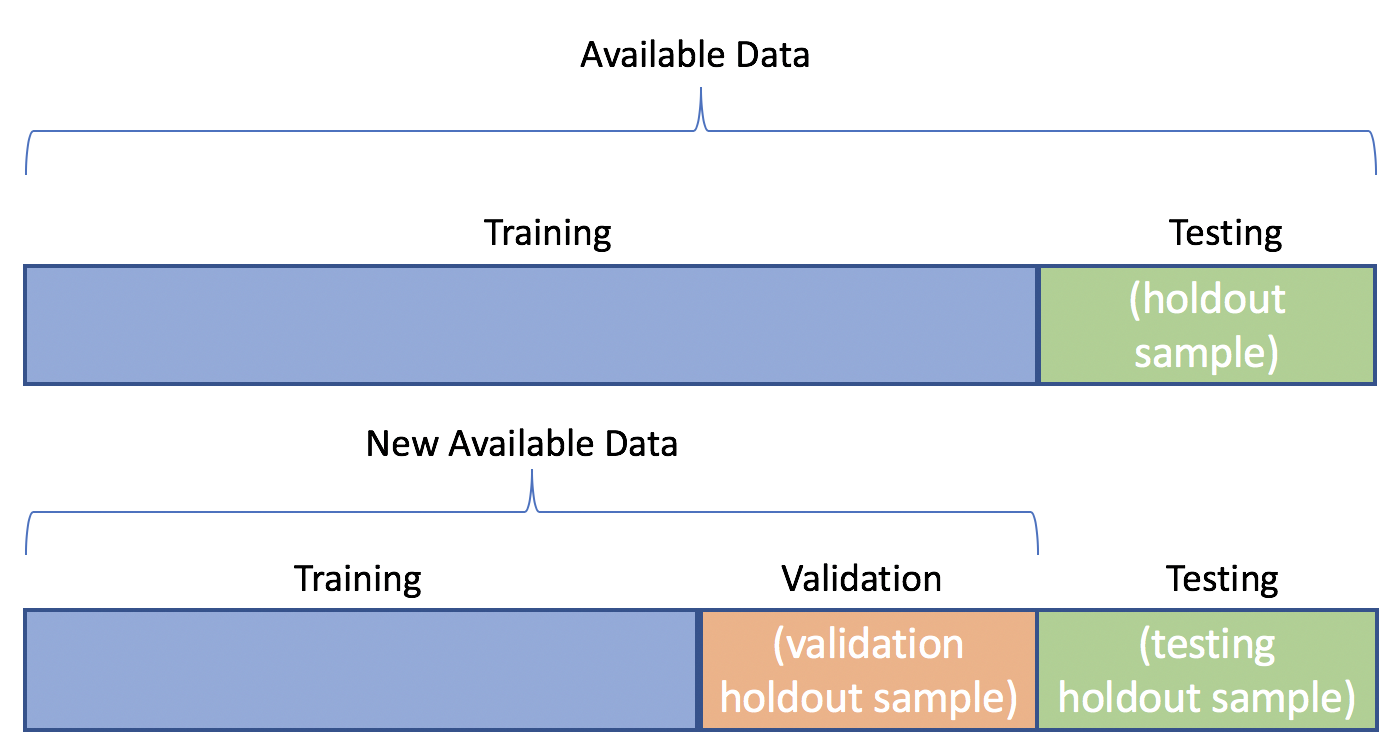

In [12]:
from IPython.display import Image
Image('https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/validation.png')

In [13]:
# Splitting into train,test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=667)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=667) # 0.25 x 0.8 = 0.2

### Normalization

In [14]:
X = X/255
X_test = X_test/255

### Setting train and validation data


## Part 1 : Exploring the Data

In [17]:
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
35873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

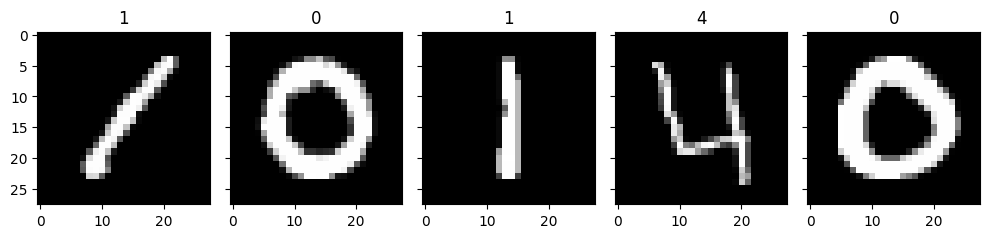

In [18]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[i].set_title(y[i])
plt.tight_layout()

### Distribution of labels

In [ ]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.countplot(y)

#### get indexes of first 10 occurences for each number


In [ ]:
li_idxs = []
for i in range(10):
    for nr in range(10):
        ix = y[y==nr].index[i]
        li_idxs.append(ix)

#### first 10 image samples for each digit

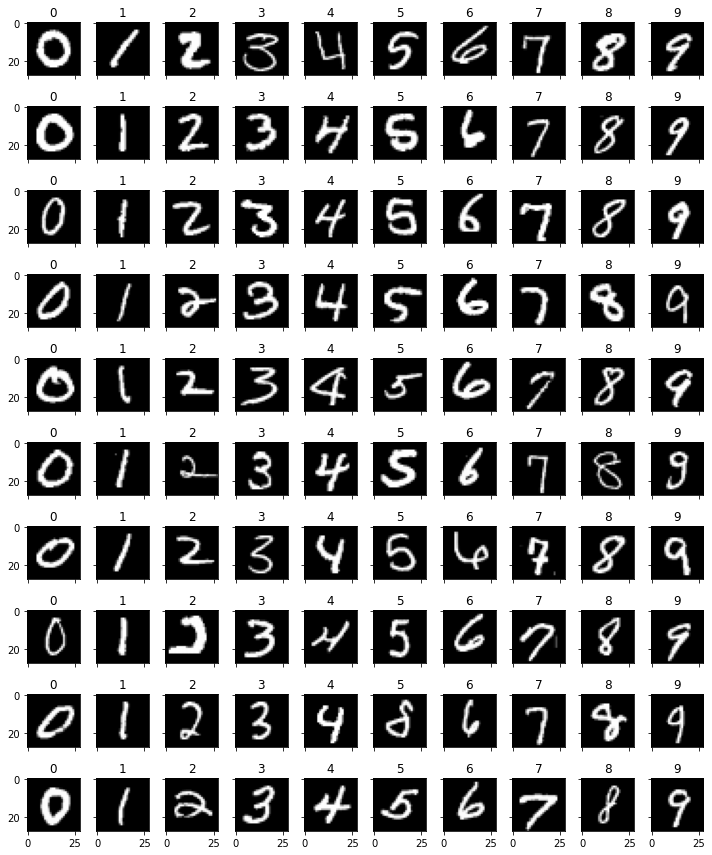

In [ ]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()
for n, i in enumerate(li_idxs):
    im = X.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(y[i])
plt.tight_layout()

### Part 2 : Sklearn Classifiers

### Logistic Regression

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LR = LogisticRegression()
LR.fit(X_train,y_train)

LogisticRegression()

In [ ]:
# from sklearn.linear_model import LogisticRegression
# clf_LR = LogisticRegression(random_state=0)
# param_grid = {'C': [0.012],
#               'multi_class': ['multinomial'],
#               'penalty': ['l1'],
#               'solver': ['saga'],
#               'tol': [0.1] }
# GridCV_LR = GridSearchCV(clf_LR, param_grid, verbose=1, cv=5)
# GridCV_LR.fit(X_train,y_train)
# score_grid_LR = get_best_score(GridCV_LR)

In [16]:
pred_lr = LR.predict(X_test)
acc_lr = print_validation_report(y_test, pred_lr)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       769
           1       0.96      0.97      0.96       944
           2       0.90      0.90      0.90       854
           3       0.89      0.88      0.88       870
           4       0.92      0.91      0.92       778
           5       0.87      0.86      0.87       740
           6       0.94      0.93      0.94       870
           7       0.92      0.93      0.93       914
           8       0.88      0.87      0.88       827
           9       0.87      0.88      0.88       834

    accuracy                           0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400

Accuracy : 0.9110714285714285


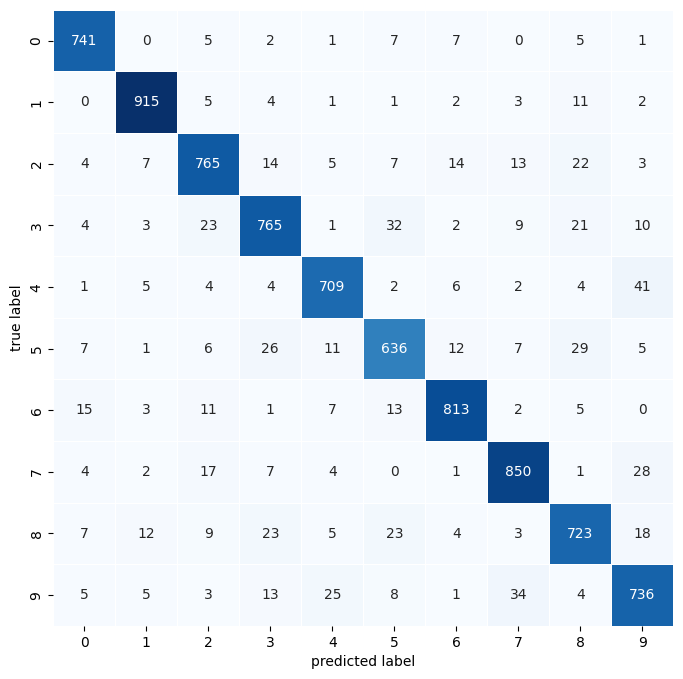

In [17]:
plot_confusion_matrix(y_test, pred_lr)

### KNN

Using GridSearchCV with KNN takes very long for this dataset.
Therefore I fit the data with one parameter: neighbors = 10
The resulting accuracy is already quite good.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [19]:
pred_knn = clf_knn.predict(X_test)
acc_knn = print_validation_report(y_test, pred_knn)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       769
           1       0.11      1.00      0.20       944
           2       0.00      0.00      0.00       854
           3       0.00      0.00      0.00       870
           4       0.00      0.00      0.00       778
           5       0.00      0.00      0.00       740
           6       0.00      0.00      0.00       870
           7       0.00      0.00      0.00       914
           8       0.00      0.00      0.00       827
           9       0.00      0.00      0.00       834

    accuracy                           0.11      8400
   macro avg       0.01      0.10      0.02      8400
weighted avg       0.01      0.11      0.02      8400

Accuracy : 0.11238095238095239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


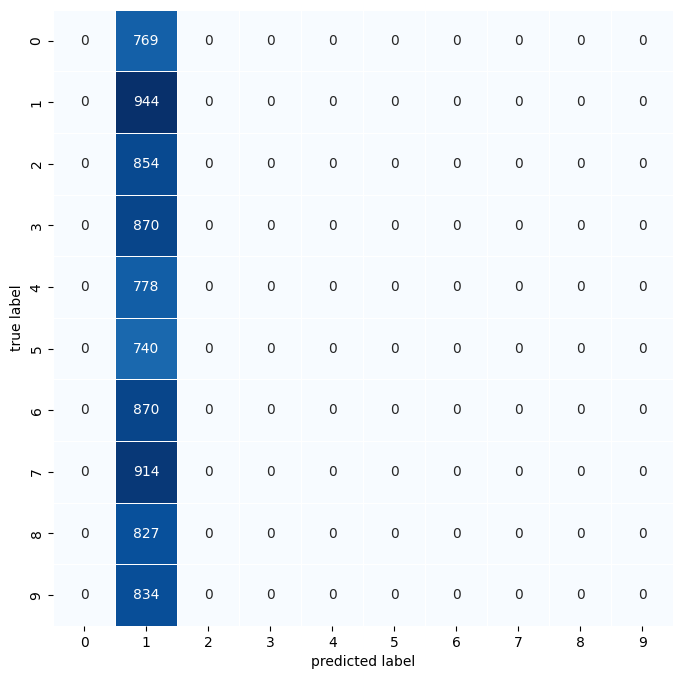

In [20]:
plot_confusion_matrix(y_test, pred_knn)

### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
#clf_RF = RandomForestClassifier(random_state=0)
RF = RandomForestClassifier(random_state=667,max_depth=15)
#param_grid = {'max_depth': [15], 'max_features': [100],
#              'min_samples_split': [5],'n_estimators' : [50] }
#GridCV_RF = GridSearchCV(clf_RF, param_grid, verbose=1, cv=5)
RF.fit(X_train,y_train)
#score_grid_RF = get_best_score(GridCV_RF)

RandomForestClassifier(max_depth=15, random_state=667)

In [22]:
pred_rf = RF.predict(X_test)

In [23]:
acc_rf = print_validation_report(y_test, pred_rf)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       769
           1       0.50      0.96      0.66       944
           2       1.00      0.00      0.00       854
           3       0.53      0.13      0.21       870
           4       0.47      0.36      0.41       778
           5       0.18      0.22      0.20       740
           6       0.00      0.00      0.00       870
           7       0.18      0.97      0.31       914
           8       0.00      0.00      0.00       827
           9       0.00      0.00      0.00       834

    accuracy                           0.28      8400
   macro avg       0.29      0.26      0.18      8400
weighted avg       0.29      0.28      0.18      8400

Accuracy : 0.27964285714285714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


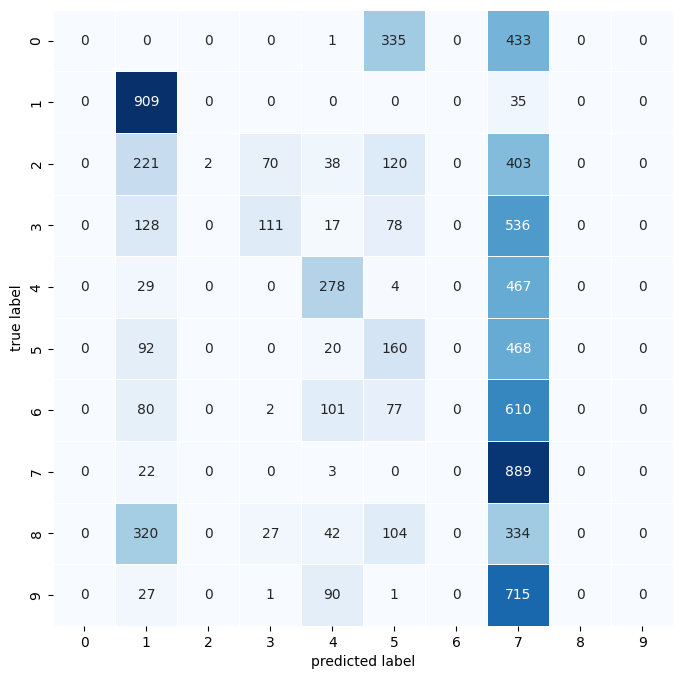

In [24]:
plot_confusion_matrix(y_test, pred_rf)

Like for KNN, GridSearchCV for SVM takes very long, so I only fit one good set of parameters here.


### Support Vector Machine Classifier

In [ ]:
# from sklearn.svm import SVC
# clf_svm = SVC(C=5, gamma=0.05, kernel='rbf', random_state=0)
# clf_svm.fit(X_train,y_train)

In [ ]:
# pred_svm = clf_svm.predict(X_test)
# acc_svm = print_validation_report(y_test, pred_svm)

In [ ]:
# plot_confusion_matrix(y_test, pred_svm)

### Perceptron

In [25]:
from sklearn.linear_model import Perceptron
# clf_Perceptron = Perceptron(random_state=0)
# param_grid = { 'penalty': ['l1','l2'], 'tol': [0.05, 0.1] }
Perceptron = Perceptron(random_state=0)
#GridCV_Perceptron = GridSearchCV(clf_Perceptron, param_grid, verbose=1, cv=5)
Perceptron.fit(X_train,y_train)
#score_grid_Perceptron = get_best_score(GridCV_Perceptron)

Perceptron()

In [26]:
pred_perc = Perceptron.predict(X_test)

In [27]:
acc_perc = print_validation_report(y_test, pred_perc)


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       769
           1       0.99      0.91      0.95       944
           2       0.94      0.78      0.85       854
           3       0.86      0.85      0.86       870
           4       0.91      0.88      0.90       778
           5       0.75      0.85      0.79       740
           6       0.94      0.94      0.94       870
           7       0.80      0.96      0.87       914
           8       0.70      0.85      0.77       827
           9       0.91      0.71      0.80       834

    accuracy                           0.87      8400
   macro avg       0.88      0.87      0.87      8400
weighted avg       0.88      0.87      0.87      8400

Accuracy : 0.8680952380952381


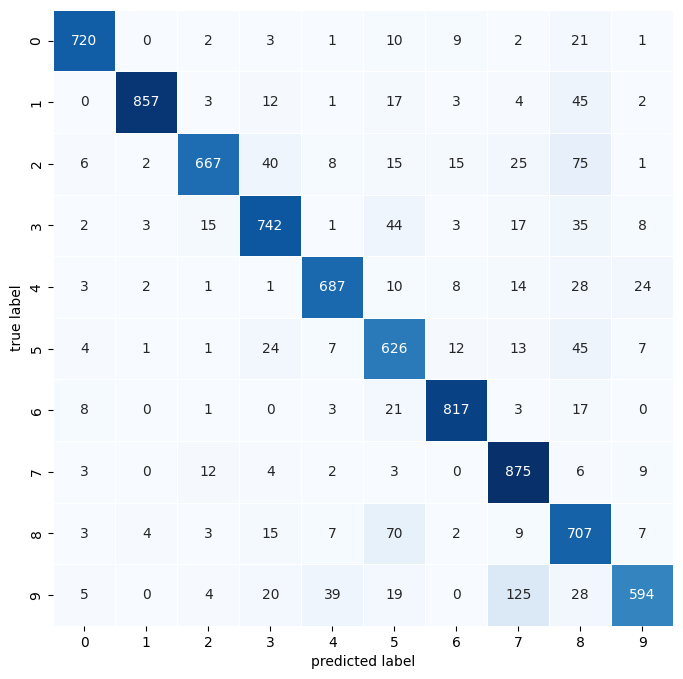

In [28]:
plot_confusion_matrix(y_test, pred_perc)

## Part 3: NN Classifiers with Keras

In [29]:
df = pd.read_csv("train.csv")

In [30]:
y = df["label"].values
X = df.drop(["label"],axis = 1).values
X = X/255.0

In [31]:
#  # Forma canonica
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=667)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=667) # 0.25 x 0.8 = 0.2

In [32]:
y_train = to_categorical(y_train, 10)
y_val_10 = to_categorical(y_val, 10)

In [33]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [34]:
y_val.shape

(8400,)

In [35]:
nr_samples = 30000
batchsize = int(nr_samples/15)

In [36]:
batchsize

2000

dense layers : every node is connected to every other node in the next layer


## NO HIDDEN LAYER - Flat input

In [38]:
def dense_model_0():
    model = Sequential()
    model.add(Dense(10, input_dim=784, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [39]:
model_dense_0 = dense_model_0()
model_dense_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model_dense_0.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=28)

Epoch 1/50
900/900 [==============================] - 3s 2ms/step - loss: 0.6062 - accuracy: 0.8463
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.3392 - accuracy: 0.9052
Epoch 3/50
900/900 [==============================] - 3s 3ms/step - loss: 0.3013 - accuracy: 0.9148
Epoch 4/50
900/900 [==============================] - 3s 3ms/step - loss: 0.2826 - accuracy: 0.9203
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.2704 - accuracy: 0.9236
Epoch 6/50
900/900 [==============================] - 3s 3ms/step - loss: 0.2615 - accuracy: 0.9259
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.2553 - accuracy: 0.9280
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 0.2500 - accuracy: 0.9288
Epoch 9/50
900/900 [==============================] - 3s 3ms/step - loss: 0.2447 - accuracy: 0.9313
Epoch 10/50
900/900 [==============================] - 2s 2ms/step - loss: 0.2418 - accuracy: 0.9313

In [ ]:
pred_dense0 = np.argmax(model_dense_0.predict(X_test), axis=-1)

In [ ]:
acc_fc0 = print_validation_report(y_test, pred_dense0)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       769
           1       0.92      0.96      0.94       944
           2       0.92      0.86      0.89       854
           3       0.88      0.89      0.88       870
           4       0.91      0.92      0.92       778
           5       0.86      0.84      0.85       740
           6       0.94      0.94      0.94       870
           7       0.94      0.91      0.93       914
           8       0.85      0.88      0.87       827
           9       0.87      0.89      0.88       834

    accuracy                           0.90      8400
   macro avg       0.90      0.90      0.90      8400
weighted avg       0.90      0.90      0.90      8400

Accuracy : 0.9044047619047619


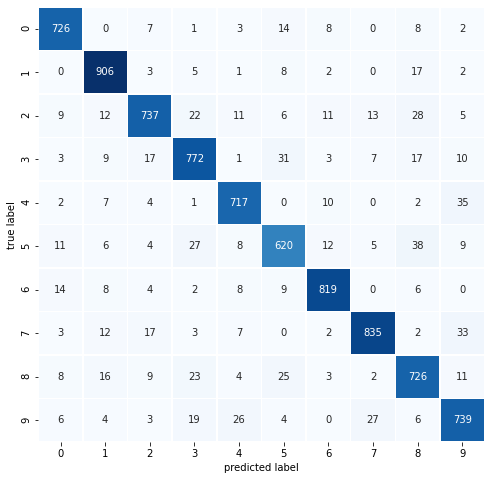

In [ ]:
plot_confusion_matrix(y_test, pred_dense0)

## Keras: 1 hidden layer -Flat Input

In [ ]:
def dense_model_1():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model_dense_1 = dense_model_1()
model_dense_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_dense_1 = model_dense_1.fit(X_train,
                                    y_train,
                                    validation_data=(X_val,y_val_10),
                                    epochs=50,
                                    batch_size=batchsize)

Epoch 1/50
13/13 [==============================] - 1s 30ms/step - loss: 1.7418 - accuracy: 0.5515 - val_loss: 1.1265 - val_accuracy: 0.7838
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 0.8443 - accuracy: 0.8140 - val_loss: 0.6147 - val_accuracy: 0.8465
Epoch 3/50
13/13 [==============================] - 0s 14ms/step - loss: 0.5273 - accuracy: 0.8641 - val_loss: 0.4548 - val_accuracy: 0.8787
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.4162 - accuracy: 0.8874 - val_loss: 0.3845 - val_accuracy: 0.8958
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 0.3613 - accuracy: 0.9008 - val_loss: 0.3480 - val_accuracy: 0.9051
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 0.3274 - accuracy: 0.9096 - val_loss: 0.3190 - val_accuracy: 0.9145
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.3022 - accuracy: 0.9167 - val_loss: 0.2986 - val_accuracy: 0.9211
Epoch 8/50
13

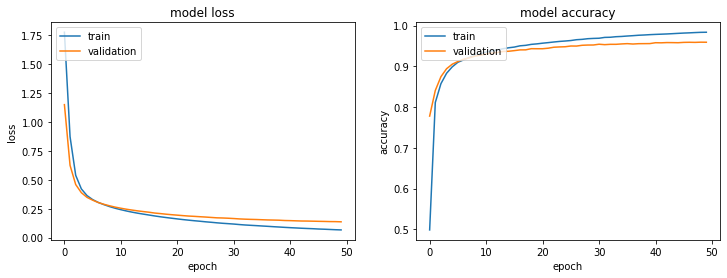

In [ ]:
plot_history_loss_and_acc(history_dense_1)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       769
           1       0.98      0.98      0.98       944
           2       0.96      0.96      0.96       854
           3       0.94      0.95      0.94       870
           4       0.96      0.94      0.95       778
           5       0.96      0.95      0.95       740
           6       0.97      0.97      0.97       870
           7       0.97      0.96      0.97       914
           8       0.95      0.95      0.95       827
           9       0.93      0.95      0.94       834

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400

0.9589285714285715


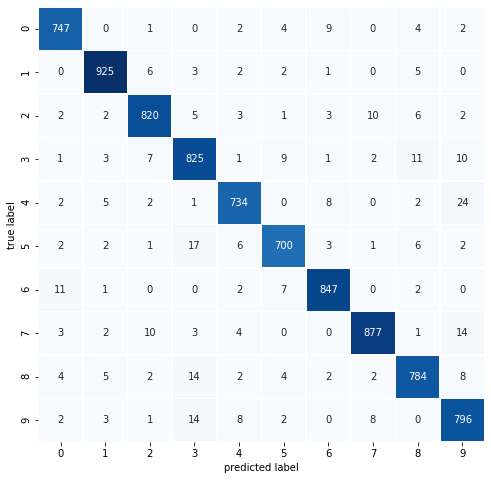

In [ ]:
pred_dense1 = np.argmax(model_dense_1.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, pred_dense1)
print(classification_report(y_test, pred_dense1))
acc_fc1 = accuracy_score(y_test, pred_dense1)
print(acc_fc1)

## Keras: 2 hidden layers - Flat input

In [ ]:
def dense_model_2():
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model_dense_2 = dense_model_2()
model_dense_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2010      
Total params: 100,710
Trainable params: 100,710
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_dense_2 = model_dense_2.fit(X_train,
                                    y_train,
                                    validation_data=(X_val,y_val_10),
                                    epochs=50,
                                    batch_size=batchsize)

Epoch 1/50
13/13 [==============================] - 1s 21ms/step - loss: 2.0636 - accuracy: 0.3516 - val_loss: 1.1434 - val_accuracy: 0.7751
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 0.9301 - accuracy: 0.8019 - val_loss: 0.5092 - val_accuracy: 0.8633
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.4620 - accuracy: 0.8706 - val_loss: 0.3651 - val_accuracy: 0.8986
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.3460 - accuracy: 0.8998 - val_loss: 0.3127 - val_accuracy: 0.9124
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.2869 - accuracy: 0.9159 - val_loss: 0.2771 - val_accuracy: 0.9200
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.2571 - accuracy: 0.9274 - val_loss: 0.2542 - val_accuracy: 0.9262
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 0.2324 - accuracy: 0.9330 - val_loss: 0.2352 - val_accuracy: 0.9337
Epoch 8/50
13/13 

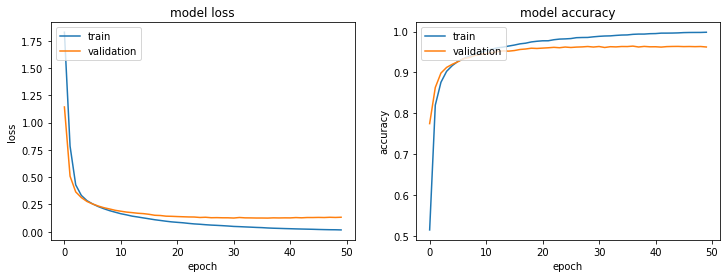

In [ ]:
plot_history_loss_and_acc(history_dense_2)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       769
           1       0.98      0.98      0.98       944
           2       0.97      0.97      0.97       854
           3       0.95      0.95      0.95       870
           4       0.98      0.96      0.97       778
           5       0.97      0.95      0.96       740
           6       0.97      0.98      0.97       870
           7       0.96      0.98      0.97       914
           8       0.97      0.96      0.97       827
           9       0.95      0.95      0.95       834

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400

0.9665476190476191


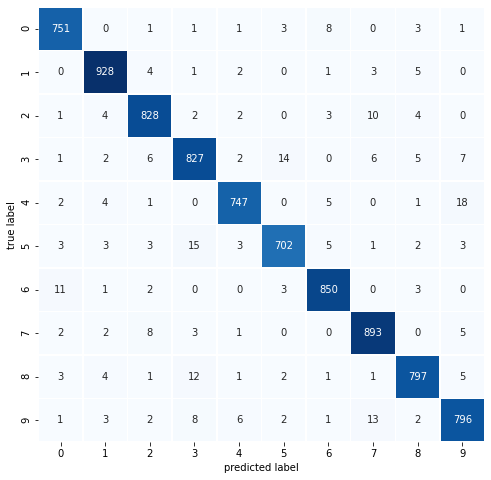

In [ ]:
pred_dense2 = np.argmax(model_dense_2.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, pred_dense2)
print(classification_report(y_test, pred_dense2))
acc_fc2 = accuracy_score(y_test, pred_dense2)
print(acc_fc2)

## Keras : Convolutional Neural Networks, CNN -  Images 28x28 2D

features : reshaping 1d vector to 2d images (784) --> (28,28,1)

In [45]:
img_rows, img_cols = 28, 28

In [46]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

Keras: CNN model 1
* Conv2D (32, (3, 3))
* Conv2D (64, (3, 3))
* Pooling2D (2,2)
* Dropout (0.25) Flatten
* Dense(128, relu)
* Dropout (0.5)
* Dense(10, softmax)

In [43]:
batchsize = 128
epochs = 12

activation = 'relu'
optimizer = Adadelta()
loss = 'categorical_crossentropy'

In [41]:
def cnn_model_1(activation):

    model = Sequential()

    # parte convolutiva
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #flatten
    model.add(Flatten())

    # Fully connected NN
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax')) #output

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

In [47]:
model_cnn_1 = cnn_model_1(activation)
model_cnn_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                      

In [48]:
#model_cnn_1.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, verbose=1)
history_cnn_1 = model_cnn_1.fit(X_train,
                                y_train,
                                validation_data=(X_val,y_val_10),
                                epochs=epochs,
                                batch_size=batchsize,
                                verbose=1)

Epoch 1/12
197/197 [==============================] - 9s 24ms/step - loss: 2.2936 - accuracy: 0.1221 - val_loss: 2.2752 - val_accuracy: 0.1345
Epoch 2/12
197/197 [==============================] - 2s 10ms/step - loss: 2.2692 - accuracy: 0.1624 - val_loss: 2.2490 - val_accuracy: 0.1933
Epoch 3/12
197/197 [==============================] - 2s 10ms/step - loss: 2.2443 - accuracy: 0.2050 - val_loss: 2.2209 - val_accuracy: 0.2742
Epoch 4/12
197/197 [==============================] - 2s 11ms/step - loss: 2.2191 - accuracy: 0.2509 - val_loss: 2.1899 - val_accuracy: 0.3792
Epoch 5/12
197/197 [==============================] - 2s 11ms/step - loss: 2.1880 - accuracy: 0.3042 - val_loss: 2.1548 - val_accuracy: 0.4752
Epoch 6/12
197/197 [==============================] - 2s 10ms/step - loss: 2.1523 - accuracy: 0.3573 - val_loss: 2.1152 - val_accuracy: 0.5446
Epoch 7/12
197/197 [==============================] - 2s 10ms/step - loss: 2.1152 - accuracy: 0.3987 - val_loss: 2.0707 - val_accuracy: 0.5917

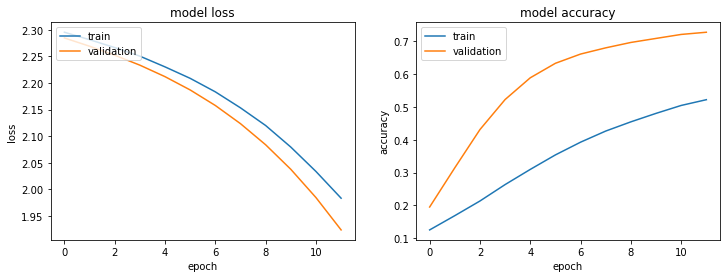

In [ ]:
plot_history_loss_and_acc(history_cnn_1)

263/263 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       769
           1       0.76      0.94      0.84       944
           2       0.92      0.55      0.69       854
           3       0.50      0.93      0.65       870
           4       0.82      0.51      0.62       778
           5       1.00      0.05      0.09       740
           6       0.77      0.89      0.83       870
           7       0.93      0.73      0.82       914
           8       0.55      0.63      0.59       827
           9       0.61      0.78      0.69       834

    accuracy                           0.70      8400
   macro avg       0.77      0.69      0.67      8400
weighted avg       0.77      0.70      0.68      8400

0.7029761904761904


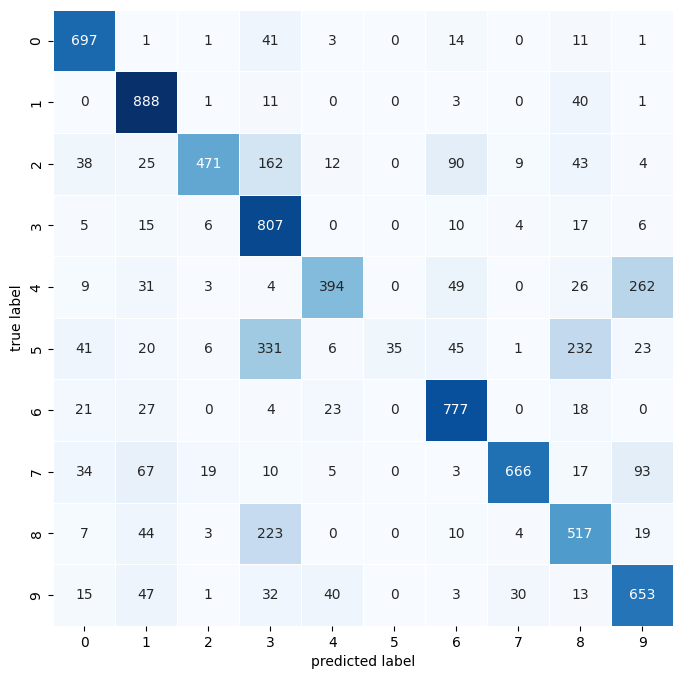

In [49]:
pred_cnn1 = np.argmax(model_cnn_1.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, pred_cnn1)
print(classification_report(y_test, pred_cnn1))
acc_cnn1 = accuracy_score(y_test, pred_cnn1)
print(acc_cnn1)

Keras: CNN model 2
* Conv2D (32, (3, 3))
* Pooling2D (2,2)
* Conv2D (32, (3, 3))
* Pooling2D (2,2)
* Flatten
* Dense(256, relu)
* Dense(10, softmax)

In [50]:
batch_size=64
epochs=40

activation = 'relu'
optimizer = Adadelta()
loss = 'categorical_crossentropy'

In [51]:
def cnn_model_2(optimizer,loss):

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'Same', activation="relu", input_shape=input_shape ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation=activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

    return model

In [52]:
model_cnn_2 = cnn_model_2(optimizer, categorical_crossentropy)
model_cnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [53]:
#model_cnn_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
history_cnn_2 = model_cnn_2.fit(X_train,
                                y_train,
                                validation_data=(X_val,y_val_10),
                                epochs=epochs,
                                batch_size=batchsize,
                                verbose=1)

Epoch 1/40
197/197 [==============================] - 4s 8ms/step - loss: 2.3017 - accuracy: 0.1849 - val_loss: 2.2987 - val_accuracy: 0.1805
Epoch 2/40
197/197 [==============================] - 1s 6ms/step - loss: 2.2941 - accuracy: 0.1995 - val_loss: 2.2910 - val_accuracy: 0.1977
Epoch 3/40
197/197 [==============================] - 1s 6ms/step - loss: 2.2863 - accuracy: 0.2190 - val_loss: 2.2830 - val_accuracy: 0.2173
Epoch 4/40
197/197 [==============================] - 1s 7ms/step - loss: 2.2783 - accuracy: 0.2471 - val_loss: 2.2749 - val_accuracy: 0.2525
Epoch 5/40
197/197 [==============================] - 1s 6ms/step - loss: 2.2701 - accuracy: 0.2844 - val_loss: 2.2665 - val_accuracy: 0.2954
Epoch 6/40
197/197 [==============================] - 1s 5ms/step - loss: 2.2615 - accuracy: 0.3242 - val_loss: 2.2577 - val_accuracy: 0.3337
Epoch 7/40
197/197 [==============================] - 1s 5ms/step - loss: 2.2525 - accuracy: 0.3609 - val_loss: 2.2483 - val_accuracy: 0.3681
Epoch 

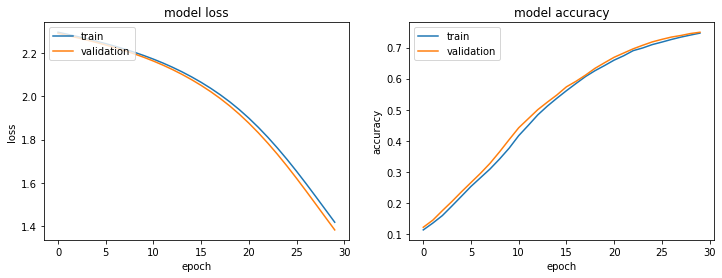

In [ ]:
plot_history_loss_and_acc(history_cnn_2)

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       769
           1       0.79      0.92      0.85       944
           2       0.84      0.69      0.76       854
           3       0.60      0.84      0.70       870
           4       0.69      0.85      0.76       778
           5       0.91      0.40      0.56       740
           6       0.80      0.80      0.80       870
           7       0.79      0.84      0.81       914
           8       0.66      0.69      0.68       827
           9       0.81      0.44      0.57       834

    accuracy                           0.74      8400
   macro avg       0.76      0.74      0.73      8400
weighted avg       0.76      0.74      0.73      8400

0.7438095238095238


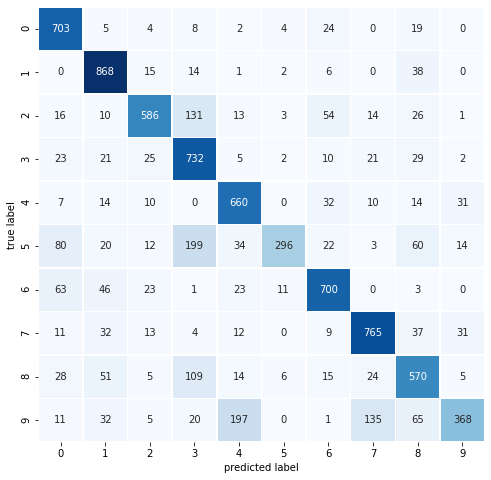

In [ ]:
pred_cnn2 = np.argmax(model_cnn_2.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, pred_cnn2)
print(classification_report(y_test, pred_cnn2))
acc_cnn2 = accuracy_score(y_test, pred_cnn2)
print(acc_cnn2)